## 1. Traffic Mortality in US

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_462/img/car-accident.jpg" alt=""></p>

<p>While the rate of fatal road accidents has been decreasing steadily since the 80s, the past ten years have seen a stagnation in this reduction. Coupled with the increase in number of miles driven in the nation, the total number of traffic related-fatalities has now reached a ten year high and is rapidly increasing.</p>
<p>Per request of the US Department of Transportation, we are currently investigating how to derive a strategy to reduce the incidence of road accidents across the nation. By looking at the demographics of traﬃc accident victims for each US state, we find that there is a lot of variation between states. Now we want to understand if there are patterns in this variation in order to derive suggestions for a policy action plan. In particular, instead of implementing a costly nation-wide plan we want to focus on groups of  states with similar profiles. 

<b>How can we find such groups in a statistically sound way and communicate the result effectively?</b></p>

<p>This data was originally collected by the National Highway Traffic Safety Administration and the National Association of Insurance Commissioners. This particular dataset was compiled and released as a <a href="https://github.com/fivethirtyeight/data/tree/master/bad-drivers">CSV-file</a> by FiveThirtyEight under the <a href="https://github.com/ﬁvethirtyeight/data">CC-BY4.0 license</a>.</p>

In [41]:
# Import the `pandas` module as "pd"

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
sns.set_style('darkgrid')



# Read in `road-accidents.csv`
car_acc = pd.read_csv('road-accidents.csv',sep='|',comment='#')

rows_and_cols = car_acc.shape
print('There are {} rows and {} columns.\n'.format(
    rows_and_cols[0], rows_and_cols[1]))

# Generate an overview of the DataFrame
car_acc_information = car_acc.info()
print(car_acc_information)

car_acc.tail()

There are 51 rows and 5 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 51 non-null     object 
 1   drvr_fatl_col_bmiles  51 non-null     float64
 2   perc_fatl_speed       51 non-null     int64  
 3   perc_fatl_alcohol     51 non-null     int64  
 4   perc_fatl_1st_time    51 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB
None


,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
46,Virginia,12.7,19,27,88
47,Washington,10.6,42,33,86
48,West Virginia,23.8,34,28,87
49,Wisconsin,13.8,36,33,84
50,Wyoming,17.4,42,32,90


### Attribute Information

* <code>State:</code> Name of the state
* <code>drvr_fatl_col_bmiles:</code> fatalities of drivers in billion miles
* <code>perc_fatl_speed:</code> percent of fatalities caused due to speed
* <code>perc_fatl_alcohol:</code> percent of fatalities caused due to drinking alcohol
* <code>perc_fatl_1s_time:</code> percent of fatalities recorded first time

<p>We now have an idea of what the dataset looks like. To further familiarize ourselves with this data, we will calculate summary statistics and produce a graphical overview of the data. The graphical overview is good to get a sense for the distribution of variables within the data and could consist of one histogram per column. It is often a good idea to also explore the pairwise relationship between all columns in the data set by using a using pairwise scatter plots (sometimes referred to as a "scatterplot matrix").</p>

### Exploratory Data Analysis

In [42]:
# Compute the summary statistics of all columns in the `car_acc` DataFrame
car_acc.describe()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


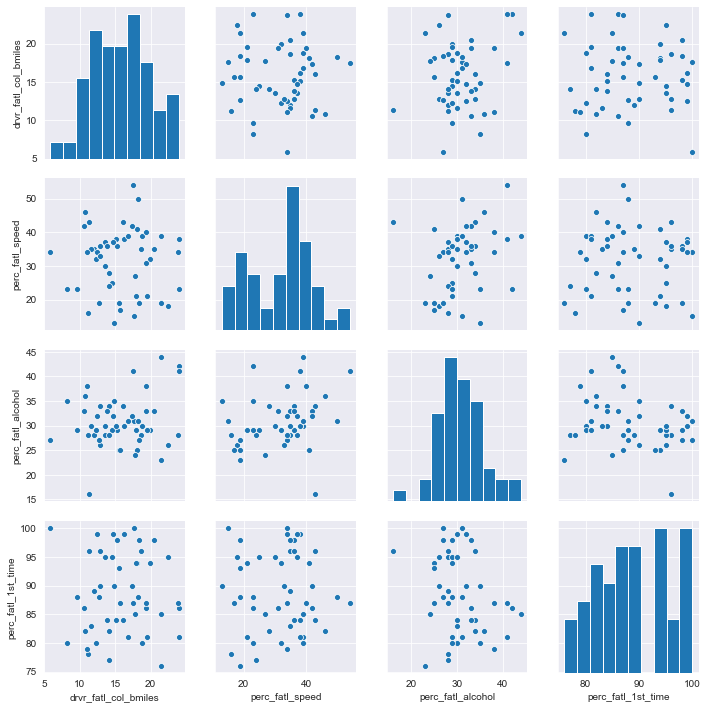

In [43]:
# Create a pairwise scatter plot to explore the data
sns.pairplot(car_acc)

<p>We can already see some potentially interesting relationships between the target variable (the number of fatal accidents) and the feature variables (the remaining three columns).</p>

<p>To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:</p>
<ul>
<li>0.2 = weak</li>
<li>0.5 = medium</li>
<li>0.8 = strong</li>
<li>0.9 = very strong</li>
</ul>

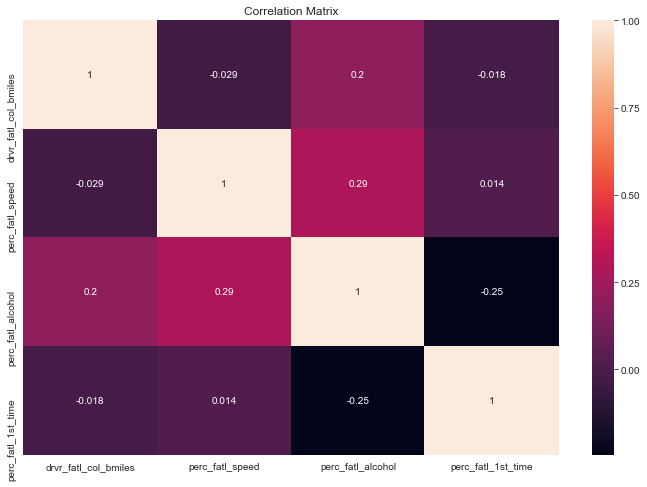

In [44]:
# Compute the correlation coefficent for all column pairs
corr_columns = car_acc.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr_columns,annot=True)
plt.title('Correlation Matrix');

<p>From the correlation table, we see that the amount of fatal accidents is most strongly correlated with alcohol consumption. But in addition, we also see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated. We, therefore, want to compute the association of the target with each feature while adjusting for the effect of the remaining features. This is done using multivariate linear regression.</p>

<p>Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we will see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.</p>

<p>A particularly interesting case is when the correlation coefficient and the regression coefficient of the same feature have opposite signs. How can this be? For example, when a feature A is positively correlated with the outcome Y but also positively correlated with a different feature B that has a negative effect on Y, then the indirect correlation (A-&gt;B-&gt;Y) can overwhelm the direct correlation (A-&gt;Y). In such a case, the regression coefficient of feature A could be positive, while the correlation coefficient is negative. This is sometimes called a <em>masking</em> relationship. Let’s see if the multivariate regression can reveal such a phenomenon.</p>

### Multivariate Linear Regression

In [45]:
# Import the linear model function from sklearn
from sklearn import linear_model

# Create the features and target DataFrames

features = car_acc.iloc[:,2:]
target = car_acc.iloc[:,1]

# Create a linear regression object
reg = linear_model.LinearRegression()

# Fit a multivariate linear regression model
reg.fit(features,target)

# Retrieve the regression coefficients
fit_coef = reg.coef_

cols = features.columns
values = dict(zip(cols,fit_coef))
values

{'perc_fatl_speed': -0.04180041330643906,
 'perc_fatl_alcohol': 0.19086403599688187,
 'perc_fatl_1st_time': 0.024733005025664008}

### Principal Component Analysis

<p>We have learned that alcohol consumption is weakly associated with the number of fatal accidents across states. <i>This could lead us to conclude that alcohol consumption should be a focus for further investigations and maybe strategies should divide states into high versus low alcohol consumption in accidents</i>. But there are also associations between  alcohol consumptions and the other two features, so it might be worth trying to split the states in a way that accounts for all three features.</p>

<p>One way of clustering the data is to use PCA to visualize data in reduced dimensional space where we can try to pick up patterns by eye. PCA uses the absolute variance to calculate the overall variance explained for each principal component, so it is important that the features are on a similar scale (unless we would have a particular reason that one feature should be weighted more).</p>

<p>We'll use the appropriate scaling function to standardize the features to be centered with mean 0 and scaled with standard deviation 1.</p>

The cumulative variance of the first two principal components is 0.7947


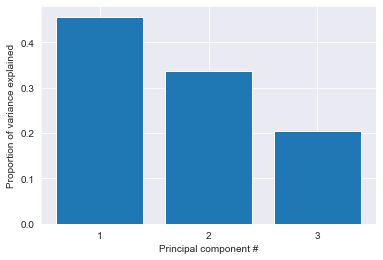

In [46]:
# Standardize and center the feature columns

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(3)

# Fit the standardized data to the pca
pca.fit(features_scaled)

# Plot the proportion of variance explained on the y-axis of the bar plot

plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)

plt.xlabel('Principal component #')
plt.ylabel('Proportion of variance explained')
plt.xticks([1, 2, 3])

# Compute the cumulative proportion of variance explained by the first two principal componenbts
two_first_comp_var_exp = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
print("The cumulative variance of the first two principal components is {}".format(
    round(two_first_comp_var_exp, 5)))

<p>The first two principal components enable visualization of the data in two dimensions while capturing a high proportion of the variation (79%) from all three features: speeding, alcohol influence, and first-time accidents. This enables us to use our eyes to try to discern patterns in the data with the goal to find groups of similar states. Although clustering algorithms are becoming increasingly efficient, human pattern recognition is an easily accessible and very efficient method of assessing patterns in data.</p>
<p>We will create a scatter plot of the first principle components and explore how the states cluster together in this visualization.</p>

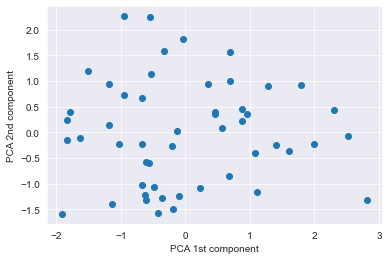

In [47]:
# Transform the scaled features using two principal components
pca = PCA(n_components=2)
p_comps = pca.fit_transform(features_scaled)

# Extract the first and second component to use for the scatter plot
p_comp1 = p_comps[:,0]
p_comp2 = p_comps[:,1]

# Plot the first two principal components in a scatter plot
plt.scatter(p_comp1,p_comp2)
plt.xlabel('PCA 1st component')
plt.ylabel('PCA 2nd component')
plt.show()

<p>It was not entirely clear from the PCA scatter plot how many groups in which the states cluster. To assist with identifying a reasonable number of clusters, we can use KMeans clustering by creating a scree plot and finding the "elbow", which is an indication of when the addition of more clusters does not add much explanatory power.</p>

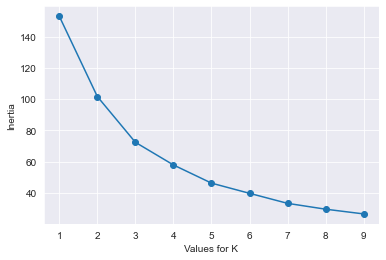

In [48]:
# A loop will be used to plot the explanatory power for up to 10 KMeans clusters
ks = range(1, 10)
inertias = []
for k in ks:
    # Initialize the KMeans object using the current number of clusters (k)
    km = KMeans(n_clusters=k, random_state=8)
    # Fit the scaled features to the KMeans object
    km.fit(features_scaled)
    # Append the inertia for `km` to the list of inertias
    inertias.append(km.inertia_)
    
# Plot the results in a line plot
plt.plot(ks,inertias, marker='o')
plt.xlabel('Values for K')
plt.ylabel('Inertia')
plt.show()

<p>Since there wasn't a clear elbow in the scree plot, assigning the states to either two or three clusters is a reasonable choice, and we will resume our analysis using three clusters. Let's see how the PCA scatter plot looks if we color the states according to the cluster to which they are assigned.</p>


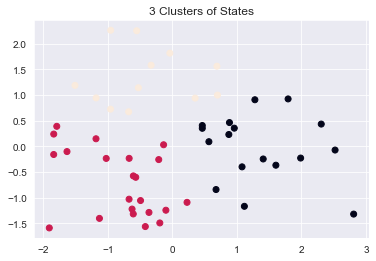

In [49]:
km = KMeans(n_clusters=3,random_state = 10)

# Fit the data to the `km` object
km.fit(features_scaled)

# Create a scatter plot of the first two principal components
# and color it according to the KMeans cluster assignment 
plt.scatter(p_comp1,p_comp2,c=km.labels_)
plt.title('3 Clusters of States')
plt.show()

<p>With this visual representation, we see three distinct clusters representing different states. However, we used scaled features and two prinicpal component to find these associations. Let's head back to using the unscaled features to help us interpret the difference.</p>

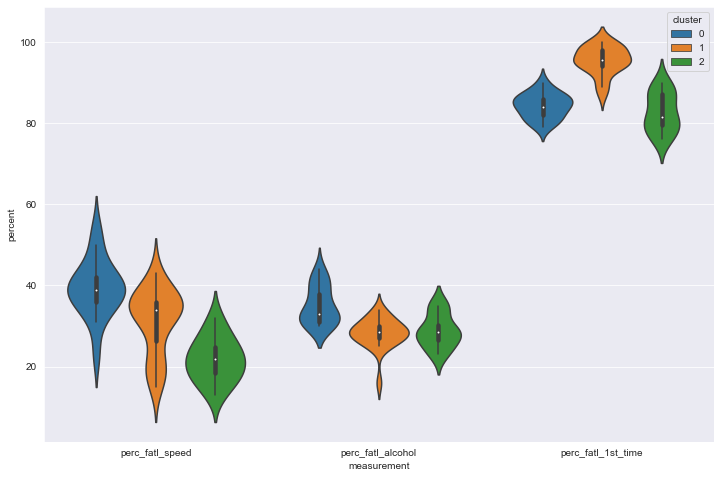

In [51]:
# Create a new column with the labels from the KMeans clustering
car_acc['cluster'] = km.labels_

# Reshape the DataFrame to the long format
melt_car = pd.melt(car_acc,id_vars=['cluster'],var_name='measurement',value_name='percent',
                   value_vars=list(features))

# Create a violin plot splitting and coloring the results according to the km-clusters
plt.figure(figsize = (12,8))
sns.violinplot(x='measurement',y='percent',hue='cluster',data=melt_car)
plt.show()

It is clear that different groups of states may require different interventions. Since resources and time are limited, it is useful to start off with an intervention in one of the three groups first. Which group would this be? To determine this, we will include data on how many miles are driven in each state, because this will help us to compute the total number of fatal accidents in each state. Data on miles driven is available in another file. We will combine this new information to see how many total fatal traffic accidents there are within each state cluster.</p>

,count,mean,sum
cluster,,,
0,17,872.132759,14826.2569
1,22,898.378595,19764.3291
2,12,920.385367,11044.6244


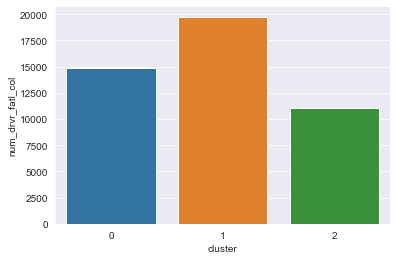

In [52]:
# Read in the new dataset
miles_driven = pd.read_csv('miles-driven.csv', sep='|')

# Merge the `car_acc` DataFrame with the `miles_driven` DataFrameb
car_acc_miles = car_acc.merge(miles_driven,on='state')

# Create a new column for the number of drivers involved in fatal accidents
car_acc_miles['num_drvr_fatl_col'] = (car_acc_miles['drvr_fatl_col_bmiles']/1000)*car_acc_miles['million_miles_annually']

# Create a barplot of the total number of accidents per cluster
sns.barplot(x='cluster', y='num_drvr_fatl_col', data=car_acc_miles, estimator=sum, ci=None)

# Calculate the number of states in each cluster and their 'num_drvr_fatl_col' mean and sum.
count_mean_sum = car_acc_miles.groupby('cluster')['num_drvr_fatl_col'].agg(['count','mean','sum'])
count_mean_sum

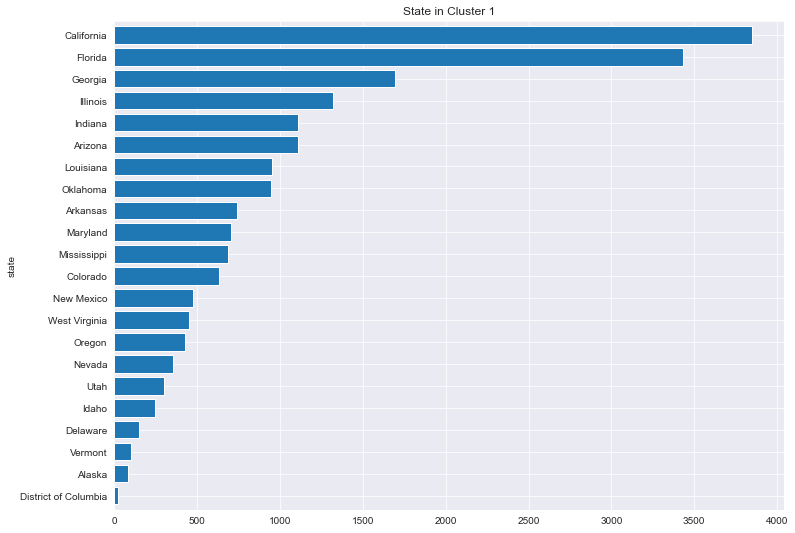

In [53]:
cluster_one = car_acc_miles[car_acc_miles['cluster']==1]
plt.figure(figsize = (12,9))
plt.title('State in Cluster 1')
cluster_one.groupby('state')['num_drvr_fatl_col'].sum().sort_values().plot.barh(width = 0.8);

#### Recommendation

Based on the miles driven in each state, we see cluster one has 22 different states with higher number of drivers involved in fatal accidents.Looking closely at the states, it is clear that initial policy intervention could potentially reduce the percentage of fatalities.